In [5]:
import pandas as pd
import numpy as np 
import polars as pl 

In [13]:
# calendar_dates = pl.read_csv('google_transit/calendar_dates.txt')
# directions = pl.read_csv('google_transit/directions.txt', schema_overrides={'direction_id': pl.Int64, 'route_short_name': pl.String})
# shapes = pl.read_csv('google_transit/shapes.txt')
# stops = pl.read_csv('google_transit/stops.txt')
# stop_times = pl.read_csv('google_transit/stop_times.txt')
# transfers = pl.read_csv('google_transit/transfers.txt')
# trips = pl.read_csv('google_transit/trips.txt')

# trips.columns=pl.Series(trips.columns).str.strip_chars()
# trips.filter(pl.col("wheelchair_accessible") == "1")

In [15]:
# path = 'google_transit/'

# files = ['calendar_dates', 'directions', 'routes', 'shapes', 'stops', 'stop_times', 'trips']

# data = {}

# for file in files:
#     data[file] = pd.read_csv(path + file + '.txt')
#     data[file].columns = data[file].columns.str.strip()
    

The data we are working with is in the GTFS (General Transit Feed Specification) format, which was created by Google to standardize public transit information. This part of the data is GTFS Static, meaning it only contains scheduled information. All of the files here are simple CSVs.

All of the static files have whitespace in the entries, presumably to line up the columns and makes them easily readable for people. However, this makes it a pain to read in Python, so I made this function to remove the whitespace when reading the files.

In [9]:
def read_file(file):
    path = 'google_transit/'
    path2 = 'transit_cleaned/'

    df = pd.read_csv(path + file + '.txt')
    df.columns = df.columns.str.strip()
    df.to_csv(path2 + file + '.txt')
    
    return df

In [11]:
# calendar = read_file('calendar').to_csv('calendar.txt')
# calendar_dates = read_file('calendar_dates').to_csv('calendar_dates.txt')
# directions = read_file('directions')
# routes = read_file('routes').to_csv('routes.txt')
# shapes = read_file('shapes').to_csv('shapes.txt')
# stops = read_file('stops').to_csv('stops.txt')
# stop_times = read_file('stop_times').to_csv('stop_times.txt')
# trips = read_file('trips').to_csv('trips.txt')

In [13]:
calendar = read_file('calendar')
calendar_dates = read_file('calendar_dates')
directions = read_file('directions')
routes = read_file('routes')
shapes = read_file('shapes')
stops = read_file('stops')
stop_times = read_file('stop_times')
trips = read_file('trips')

In [59]:
calendar = calendar.drop(columns='Unnamed: 0')
calendar_dates = calendar_dates.drop(columns='Unnamed: 0')
directions = directions.drop(columns='')
routes = routes.drop(columns=['', 'route_desc', 'agency_id', 'route_url'])
shapes = shapes.drop(columns='Unnamed: 0')
stops = stops.drop(columns=['', 'stop_desc', 'stop_url'])
stop_times = stop_times.drop(columns=['Unnamed: 0', 'stop_headsign'])
trips = trips.drop(columns=['', 'trip_short_name'])

Each route has a unique route_id, as well as a publically used route number (route_short_name). There are 5 different route types: 1 (SkyTrain), 2 (West Coast Express), 3 (Bus), 4 (SeaBus), and 715 (HandyDart). I wonder why they used a 3 digit number for HandyDart?

In [9]:
routes.dtypes

Unnamed: 0           int64
Unnamed: 1           int64
route_id            object
agency_id           object
route_short_name    object
route_long_name     object
route_desc          object
route_type           int64
route_url           object
route_color         object
route_text_color    object
dtype: object

Shapes contains coordinates and distance travelled for each route. Every route has a unique shape_id.

In [85]:
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,292022,49.257645,-123.172280,1,0.0000
1,292022,49.262254,-123.168244,10,0.8022
2,292022,49.262340,-123.168239,11,0.8118
3,292022,49.263215,-123.168220,12,0.9091
4,292022,49.264080,-123.168160,13,1.0054
...,...,...,...,...,...
157642,298196,49.262040,-122.781914,96,8.9825
157643,298196,49.261287,-122.782683,97,9.0832
157644,298196,49.261286,-122.782683,98,9.0833
157645,298196,49.260879,-122.782687,99,9.1286


Each stop has a unique stop_id, and a publically used stop_code, as well as coordinates. There are 11 different zones: 1 Bus, 6 West Coast Express (not sure what A and Z mean), and 4 SkyTrain (CL_AD = Canada Line Airport D(estination?))

In [22]:
stops['zone_id'].unique()

array(['BUS ZN  ', 'ZN 1    ', 'ZN 2    ', 'CL_AD   ', 'WCE1A   ',
       'ZN 3    ', 'WCE2A   ', 'WCE1Z   ', 'WCE2Z   ', 'WCE3Z   ',
       'WCE4Z   '], dtype=object)

In [24]:
stops

,,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding
0,0,1,50001,Westbound Davie St @ Bidwell St ...,,49.286458,-123.140424,BUS ZN,,0,,1
1,1,10000,59326,Northbound No. 5 Rd @ McNeely Dr ...,,49.179962,-123.091490,BUS ZN,,0,,1
2,2,10001,59324,Northbound No. 5 Rd @ Woodhead Rd ...,,49.182670,-123.091448,BUS ZN,,0,,1
3,3,10002,59323,Southbound No. 5 Rd @ Cambie Rd ...,,49.184252,-123.091627,BUS ZN,,0,,1
4,4,10003,59325,Southbound No. 5 Rd @ Woodhead Rd ...,,49.182051,-123.091659,BUS ZN,,0,,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8784,99954,,Pitt Meadows Station ...,,49.225796,-122.688379,WCE3Z,,1,,1
8785,8785,99955,,Maple Meadows Station ...,,49.216513,-122.666210,WCE3Z,,1,,1
8786,8786,99956,,Port Haney Station ...,,49.212202,-122.605240,WCE3Z,,1,,1
8787,8787,99957,,Mission City Station ...,,49.133694,-122.304898,WCE4Z,,1,,1


Each trip has a unique trip_id, as well as a route_id and shape_id. The wheelchair_accesible attribute would've been a nice statistic to have, however, every single trip except for HandyDart has this value as 0, which is definitely not correct. 

In [152]:
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,6612,1,13997545,2 Macdonald/To Burrard Station ...,0,2099312,292023,0,1
1,6612,1,13997546,2 Macdonald/To Burrard Station ...,0,2099318,292023,0,1
2,6612,1,13997547,2 Macdonald/To Burrard Station ...,0,2099321,292023,0,1
3,6612,1,13997548,2 Macdonald/To Burrard Station ...,0,2099322,292023,0,1
4,6612,1,13997549,2 Macdonald/To Burrard Station ...,0,2099312,292023,0,1
...,...,...,...,...,...,...,...,...,...
60992,31822,1,14321214,741 Anderson Creek ...,0,2123239,293067,0,1
60993,31822,1,14321215,741 Haney Place ...,1,2123239,293070,0,1
60994,6651,101,14321448,130 Willingdon/To Metrotown Station ...,1,2107629,294477,0,1
60995,6646,201,14321449,110 Lougheed Station ...,0,2107629,292358,0,1


Merging trips and routes maps route_short_name and route_type to shape_id.

In [66]:
routes_trips = pd.merge(trips.astype('string'), routes.astype('string'), on='route_id', how='left')

In [68]:
routes_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,6612,1,13997545,2 Macdonald/To Burrard Station ...,,0,2099312,292023,0,1,TL,002,Macdonald/Burrard Station ...,,3,,,<NA>
1,6612,1,13997546,2 Macdonald/To Burrard Station ...,,0,2099318,292023,0,1,TL,002,Macdonald/Burrard Station ...,,3,,,<NA>
2,6612,1,13997547,2 Macdonald/To Burrard Station ...,,0,2099321,292023,0,1,TL,002,Macdonald/Burrard Station ...,,3,,,<NA>
3,6612,1,13997548,2 Macdonald/To Burrard Station ...,,0,2099322,292023,0,1,TL,002,Macdonald/Burrard Station ...,,3,,,<NA>
4,6612,1,13997549,2 Macdonald/To Burrard Station ...,,0,2099312,292023,0,1,TL,002,Macdonald/Burrard Station ...,,3,,,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60992,31822,1,14321214,741 Anderson Creek ...,,0,2123239,293067,0,1,TL,741,Anderson Creek/Haney Place/Port Haney St ...,,3,,,<NA>
60993,31822,1,14321215,741 Haney Place ...,,1,2123239,293070,0,1,TL,741,Anderson Creek/Haney Place/Port Haney St ...,,3,,,<NA>
60994,6651,101,14321448,130 Willingdon/To Metrotown Station ...,,1,2107629,294477,0,1,TL,130,Metrotown/Pender/Kootenay ...,,3,,,<NA>
60995,6646,201,14321449,110 Lougheed Station ...,,0,2107629,292358,0,1,TL,110,Lougheed Station/Metrotown Station ...,,3,,,<NA>


We then map the combined data to shapes, which will allow us to filter the geographic date by route and type.

In [161]:
shapes_with_routes = pd.merge(shapes.astype('string'), routes_trips[['shape_id', 'route_short_name', 'route_type']], on='shape_id', how='left')
shapes_with_routes = shapes_with_routes.drop_duplicates()
shapes_with_routes[['shape_id', 'route_type', 'shape_pt_sequence']] = shapes_with_routes[['shape_id', 'route_type', 'shape_pt_sequence']].astype('int64')
shapes_with_routes[['shape_pt_lat', 'shape_pt_lon', 'shape_dist_traveled']] = shapes_with_routes[['shape_pt_lat', 'shape_pt_lon', 'shape_dist_traveled']].astype('float64')

In [ ]:
# trips.where(trips['wheelchair_accessible'] == 0)
#test = trips[trips['bikes_allowed'] == 2]
#test
# test = trips.drop_duplicates(subset='route_id', keep='last')
# test
# test2 = trips[trips['bikes_allowed'] == 2].drop_duplicates('route_id', keep='last')
# test2
# test3 = trips[trips['bikes_allowed'] == 1].drop_duplicates('route_id', keep='last')
# test3

# test = stops
# stops['zone_id'].str.extract(r'(CL_AD)')
# test['example'] = stops['zone_id'].str.extract(r'(CL_AD)')
# test.dropna()

In [37]:
trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,6612,1,13997545,2 Macdonald/To Burrard Station ...,,0,2099312,292023,0,1
1,6612,1,13997546,2 Macdonald/To Burrard Station ...,,0,2099318,292023,0,1
2,6612,1,13997547,2 Macdonald/To Burrard Station ...,,0,2099321,292023,0,1
3,6612,1,13997548,2 Macdonald/To Burrard Station ...,,0,2099322,292023,0,1
4,6612,1,13997549,2 Macdonald/To Burrard Station ...,,0,2099312,292023,0,1
...,...,...,...,...,...,...,...,...,...,...
60992,31822,1,14321214,741 Anderson Creek ...,,0,2123239,293067,0,1
60993,31822,1,14321215,741 Haney Place ...,,1,2123239,293070,0,1
60994,6651,101,14321448,130 Willingdon/To Metrotown Station ...,,1,2107629,294477,0,1
60995,6646,201,14321449,110 Lougheed Station ...,,0,2107629,292358,0,1


In [53]:
# https://stackoverflow.com/questions/69658517/pandas-drop-row-if-theres-only-one-occurrence-of-a-value

In [65]:
# test = shapes[shapes.columns[shapes['shape_id'].value_counts() > 1]]
path = 'transit_cleaned/'

is_multi = shapes["shape_id"].value_counts() > 1
shapes = shapes[shapes["shape_id"].isin(is_multi[is_multi].index)]

shapes.to_csv(path + 'shapes.txt')
stop_times.to_csv(path + 'stop_times.txt')

In [57]:
filtered

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,292022,49.257645,-123.172280,1,0.0000
1,292022,49.262254,-123.168244,10,0.8022
2,292022,49.262340,-123.168239,11,0.8118
3,292022,49.263215,-123.168220,12,0.9091
4,292022,49.264080,-123.168160,13,1.0054
...,...,...,...,...,...
157641,298196,49.262832,-122.781135,95,8.8777
157642,298196,49.262040,-122.781914,96,8.9825
157643,298196,49.261287,-122.782683,97,9.0832
157644,298196,49.261286,-122.782683,98,9.0833


In [69]:
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,10232,TL,256,Whitby Estate/Park Royal/Spuraway ...,,3,,,NaN
1,11201,TL,033,29th Avenue Station/UBC ...,,3,,,NaN
2,11692,TL,364,Langley Centre/Scottsdale ...,,3,,,NaN
3,11693,TL,388,22nd St Station/Carvolth Exchange ...,,3,,,NaN
4,11696,TL,609,South Delta Exchange/Ladner Exchange ...,,3,,,NaN
...,...,...,...,...,...,...,...,...,...
233,8286,TL,370,Cloverdale/Willowbrook ...,,3,,,NaN
234,8289,TL,865,Samuel Robertson ...,,3,,,NaN
235,8290,TL,341,Guildford/Newton Exchange ...,,3,,,NaN
236,9745,TL,418,Kingswood/22nd St Station ...,,3,,,NaN


In [71]:
route_info = routes[['route_id', 'route_short_name', 'route_type']]

In [73]:
route_info

,route_id,route_short_name,route_type
0,10232,256,3
1,11201,033,3
2,11692,364,3
3,11693,388,3
4,11696,609,3
...,...,...,...
233,8286,370,3
234,8289,865,3
235,8290,341,3
236,9745,418,3


In [75]:
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,10232,TL,256,Whitby Estate/Park Royal/Spuraway ...,,3,,,NaN
1,11201,TL,033,29th Avenue Station/UBC ...,,3,,,NaN
2,11692,TL,364,Langley Centre/Scottsdale ...,,3,,,NaN
3,11693,TL,388,22nd St Station/Carvolth Exchange ...,,3,,,NaN
4,11696,TL,609,South Delta Exchange/Ladner Exchange ...,,3,,,NaN
...,...,...,...,...,...,...,...,...,...
233,8286,TL,370,Cloverdale/Willowbrook ...,,3,,,NaN
234,8289,TL,865,Samuel Robertson ...,,3,,,NaN
235,8290,TL,341,Guildford/Newton Exchange ...,,3,,,NaN
236,9745,TL,418,Kingswood/22nd St Station ...,,3,,,NaN


In [23]:
data = stops['wheelchair_boarding']

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

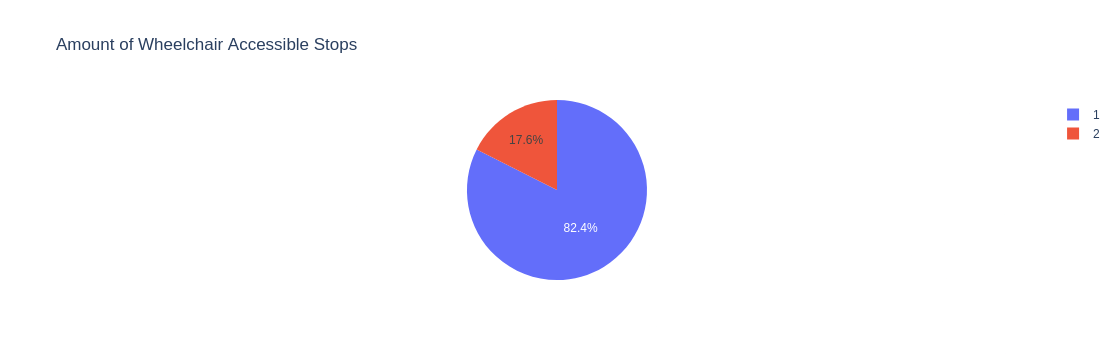

In [74]:

fig = px.pie(stops, values='stop_id', names='wheelchair_boarding', title='Amount of Wheelchair Accessible Stops')
fig.show()

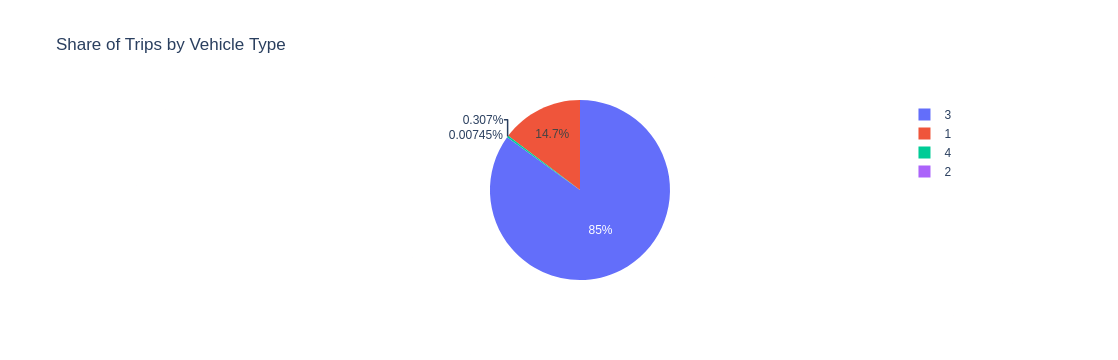

In [72]:
fig2 = px.pie(routes_trips, values='route_id', names='route_type', title='Share of Trips by Vehicle Type')
fig2.show()